# Dependencies

In [ ]:
!pip install timm transformers gdown
!pip install scikit-learn seaborn

### Importing modules

In [2]:
import os
import itertools
import random
import json
from typing import Any, Callable, List, Optional, Tuple, Dict
random.seed(42)

import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
# from tqdm import tqdm
import matplotlib.pyplot as plt
# import cv2
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import timm
# import albumentations as A
import torchvision.transforms as transforms
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

In [3]:
dataset = 'coco_single_class'
media_dir = './media'
if not os.path.exists(dataset):
    !gdown --fuzzy https://drive.google.com/file/d/1FfQfy1msqZXEz6S_wac2FtWoVvWPUO8y/view?usp=sharing
    !tar -xvf ./coco_single_class.tar.gz
if not os.path.exists(media_dir):    
    # Download images for notebook
    !gdown --fuzzy --folder https://drive.google.com/drive/folders/1qi7e9IakpNMDkyP0YonuKfxPq0tIxvmf?usp=sharing

# Project 2 - Multimodal and Missing Data

## Config
Below is a CFG class to store all model hyperparameters.

In [4]:
class CFG:
    debug = False
    # image_path = image_path
    # captions_path = captions_path
    max_samples = 10000 # max number of dataset samples to load (-1 for all samples)
    batch_size = 64
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 10  # you can train for more epochs if you have the time and want to see better performance
    random_seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 91

    model_name = 'tiny_vit_21m_224.dist_in22k_ft_in1k'
    image_embedding = 576
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_token_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0 # this is a learnable parameter in CLIP, but we ignore that for this demo

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

## Dataset Class
We will be using the pre-made COCOSingleClassDataset class to load the data from the raw json files. This class is also setup as a PyTorch Dataset, which will make training the model easier later on.

In [88]:
def keystoint(annot_dict):
    for top_key, top_val in annot_dict.items():
        if top_key in ['annotations', 'class_name_dict']:
            annot_dict[top_key] = {int(k): v for k, v in annot_dict[top_key].items()}
    return annot_dict

class COCOSingleClassDataset(Dataset):
    """
    Torch Dataset for custom COCO split. Contains only images with a single
    class label, and has 5 captions per image.

    Batches return image, label, caption, and optionally tokenised captions.    
    """
    def __init__(
        self,
        data_dir: str,
        split: str = 'train2017',
        transforms: Optional[Callable] = None,
        tokenizer: Optional[Callable] = None,
        max_token_length: int = 200,
        max_samples: int = -1,
        max_captions_per_image: int = 5,
        drop_data_ratio=0,
        drop_data_mode=None
    ) -> None:
        """
        Constructs the Dataset object.

        Parameters
        ----------
            data_dir : str
                dataset root directory
            split : str
                coco split to use, must be 'train2017' or 'val2017'
            transforms : Optional[Callable]
                pytorch transforms to apply to the images, typically a transforms.Compose() object or None
            tokenizer : Optional[Callable]
                tokenizer to apply to the captions, expects a HuggingFace tokenizer or None if not tokenizing
            max_token_length: int
                max length of tokens, if using tokenizer
            max_samples: int
                max number of samples to load from dataset, useful for debugging, value of -1 loads all samples
            max_captions_per_image: int
                max number of captions to load per image, set to 1 if evaluating image classification performance
        """
        assert max_captions_per_image <= 5, 'Only 5 captions available per image'
        assert max_captions_per_image > 0, 'Minimum 1 caption per image'
        assert split in ['train2017', 'val2017'], 'Invalid split'
        
        self.data_dir = data_dir
        self.split = split
        self.img_dir = os.path.join(self.data_dir, self.split)
        self.transforms = transforms
        self.tokenizer = tokenizer
        self.max_token_length = max_token_length
        self.max_samples = max_samples
        self.max_captions_per_image = max_captions_per_image
        self.random_seed = 42
        self.drop_data_ratio = drop_data_ratio
        self.drop_data_mode = drop_data_mode
        
        random.seed(self.random_seed)
        self.load_annotations()
        self.img_ids = self._annot_dict['ids']
        self.annotations = self._annot_dict['annotations']
        self.class_name_dict = self._annot_dict['class_name_dict']
        self.generate_samples()

    def __len__(self) -> int:
        return len(self.df_samples)

    def __getitem__(self, idx: int) -> Dict:
        """
        This function will be called automatically when loading batches from
        the dataloader. Batches are returned as a Dictionary object, with the 
        keys:        
            image : torch.Tensor[torch.float32]
                tensor of dim [B, C, H, W]
            label : torch.Tensor[torch.uint8]
                classification labels of each item in batch
            caption : str
                original caption, for visualisation or debugging purposes
            input_ids : torch.Tensor[torch.int64]
                if using tokenizer, returns a tensor containing tokenised captions
            attention_mask : torch.Tensor[torch.int64]
                if using tokenizer, returns a tensor containing attention masks for tokens
        """
        sample = self.df_samples.iloc[idx]
        item = {}
        img_id = sample['id']
        img_path = sample['image']
        if img_path == "": # has img been dropped?
            item['image'] = Image.new('RGB', (CFG.size, CFG.size), (0,0,0))
        else:
            item['image'] = Image.open(img_path).convert('RGB')
            assert(item['image'].mode == 'RGB'), f"Invalid # channels for img {img_id}"
            if self.transforms is not None:
                item['image'] = self.transforms(item['image'])
        if type(item['image']) is not torch.Tensor:  # ensure image is converted to a Tensor
            temp_transform = transforms.ToTensor()
            item['image'] = temp_transform(item['image'])
        item['label'] = torch.tensor(sample['label'], dtype=torch.uint8)
        item['caption'] = sample['caption']
        item['input_ids'] = torch.tensor(sample['input_ids'])
        item['attention_mask'] = torch.tensor(sample['attention_mask'])
        return item

    def load_annotations(self) -> None:
        """
        Load annotations from JSON.
        """
        annot_file = os.path.join(
            self.data_dir, 'annotations', f"annotations_{self.split}.json"
        )
        with open(annot_file, "r") as f:
            annot_dict = json.load(f)
        self._annot_dict = keystoint(annot_dict)
        # Only use subset of annots if specified
        if self.max_samples > 0:
            if self.max_samples >= len(self._annot_dict['ids']): # Already less than max_samples available
                return
            ids_kept = sorted(random.sample(self._annot_dict['ids'], self.max_samples))
            self._annot_dict['ids'] = ids_kept
            self._annot_dict['annotations'] = {k: v for k, v in self._annot_dict['annotations'].items() if k in ids_kept}
        
    def generate_samples(self) -> None:
        """
        Generates dataframe of samples for every img, caption pair. Accessible
        with self.df_samples, useful for manually comparing images and captions.
        """
        print(f'Generating {self.split} samples...')
        samples = []
        captions_all = []
        for i, idx in enumerate(tqdm(self._annot_dict['ids'])):
            to_drop = i / len(self._annot_dict['ids']) < self.drop_data_ratio
            # print(f"{i} / {len(self._annot_dict['ids'])}")
            # Get all annotations associated with image       
            img_annots = self.annotations[idx]
            # img drop
            if (to_drop and self.drop_data_mode == "image"):
                img_path = ""
            else:
                img_path = os.path.join(self.img_dir, img_annots['file_name'])
                # Check image is not corrupted
                try:
                    _ = Image.open(img_path).convert('RGB')
                except:
                    print(f"Skipped corrupted image {img_path}")
                    continue
            label = img_annots['category_id']
            captions = img_annots['captions']
            # txt drop
            if (to_drop and self.drop_data_mode == "text"):
                captions = [""]
            # Only load number of captions specified as samples
            if self.max_captions_per_image < 5:
                captions = captions[:self.max_captions_per_image]
            captions_all.extend(captions)
            # Add all associated captions
            for caption in captions:
                if self.tokenizer is not None:
                    samples.append([idx, img_path, label, caption])
                else:
                    samples.append([idx, img_path, label, caption, None, None])
        # Tokenize captions
        if self.tokenizer is not None:
            encoded_captions = self.tokenizer(
                captions_all, padding=True, truncation=True, max_length=self.max_token_length
            )
            for idx in range(len(samples)):
                samples[idx].append(encoded_captions['input_ids'][idx])
                samples[idx].append(encoded_captions['attention_mask'][idx])
        # Save to df
        self.df_samples = pd.DataFrame(samples, columns=['id','image','label','caption', 'input_ids', 'attention_mask'])
        
    def get_class_name(self, label: int) -> str:
        """
        Return class label for given class id.
        
        Parameters
        ----------
            label : int
                class id, stored as the 'label' element in df_samples

        Returns
        -------
            class_name : str
                class name associated with input class id
        """
        class_name = self.class_name_dict[label]
        return class_name
            

## Some Pre-processing
The function allows us to grab `df_samples`, which is a Pandas dataframe containing image/caption/label training samples.

In [89]:
if dataset == 'coco_single_class':
  data_path = "./coco_single_class"
  COCO_dataset_preview = COCOSingleClassDataset(data_dir=data_path,
                                                split='val2017',
                                                transforms=None)

img_ids = COCO_dataset_preview.img_ids
annotations = COCO_dataset_preview.annotations
img_dir = COCO_dataset_preview.img_dir
df_samples = COCO_dataset_preview.df_samples
# Print a data sample                    samples.append([idx, img_path, label, ""])

sample = df_samples.iloc[100]
print(sample)
# The 'get_class_name' function of the dataset will get the class name associated with the category_id
get_class_name = COCO_dataset_preview.get_class_name
print(f"\nClass: {sample['label']} = {get_class_name(sample['label'])}")

Generating val2017 samples...


  0%|          | 0/1025 [00:00<?, ?it/s]

0 / 1025
1 / 1025
2 / 1025
3 / 1025
4 / 1025
5 / 1025
6 / 1025
7 / 1025
8 / 1025
9 / 1025
10 / 1025
11 / 1025
12 / 1025
13 / 1025
14 / 1025
15 / 1025
16 / 1025
17 / 1025
18 / 1025
19 / 1025
20 / 1025
21 / 1025
22 / 1025
23 / 1025
24 / 1025
25 / 1025
26 / 1025
27 / 1025
28 / 1025
29 / 1025
30 / 1025
31 / 1025
32 / 1025
33 / 1025
34 / 1025
35 / 1025
36 / 1025
37 / 1025
38 / 1025
39 / 1025
40 / 1025
41 / 1025
42 / 1025
43 / 1025
44 / 1025
45 / 1025
46 / 1025
47 / 1025
48 / 1025
49 / 1025
50 / 1025
51 / 1025
52 / 1025
53 / 1025
54 / 1025
55 / 1025
56 / 1025
57 / 1025
58 / 1025
59 / 1025
60 / 1025
61 / 1025
62 / 1025
63 / 1025
64 / 1025
65 / 1025
66 / 1025
67 / 1025
68 / 1025
69 / 1025
70 / 1025
71 / 1025
72 / 1025
73 / 1025
74 / 1025
75 / 1025
76 / 1025
77 / 1025
78 / 1025
79 / 1025
80 / 1025
81 / 1025
82 / 1025
83 / 1025
84 / 1025
85 / 1025
86 / 1025
87 / 1025
88 / 1025
89 / 1025
90 / 1025
91 / 1025
92 / 1025
93 / 1025
94 / 1025
95 / 1025
96 / 1025
97 / 1025
98 / 1025
99 / 1025
100 / 1025

In [60]:
df_samples.label.unique().max()

90

And lets visualise some images with their associated captions.

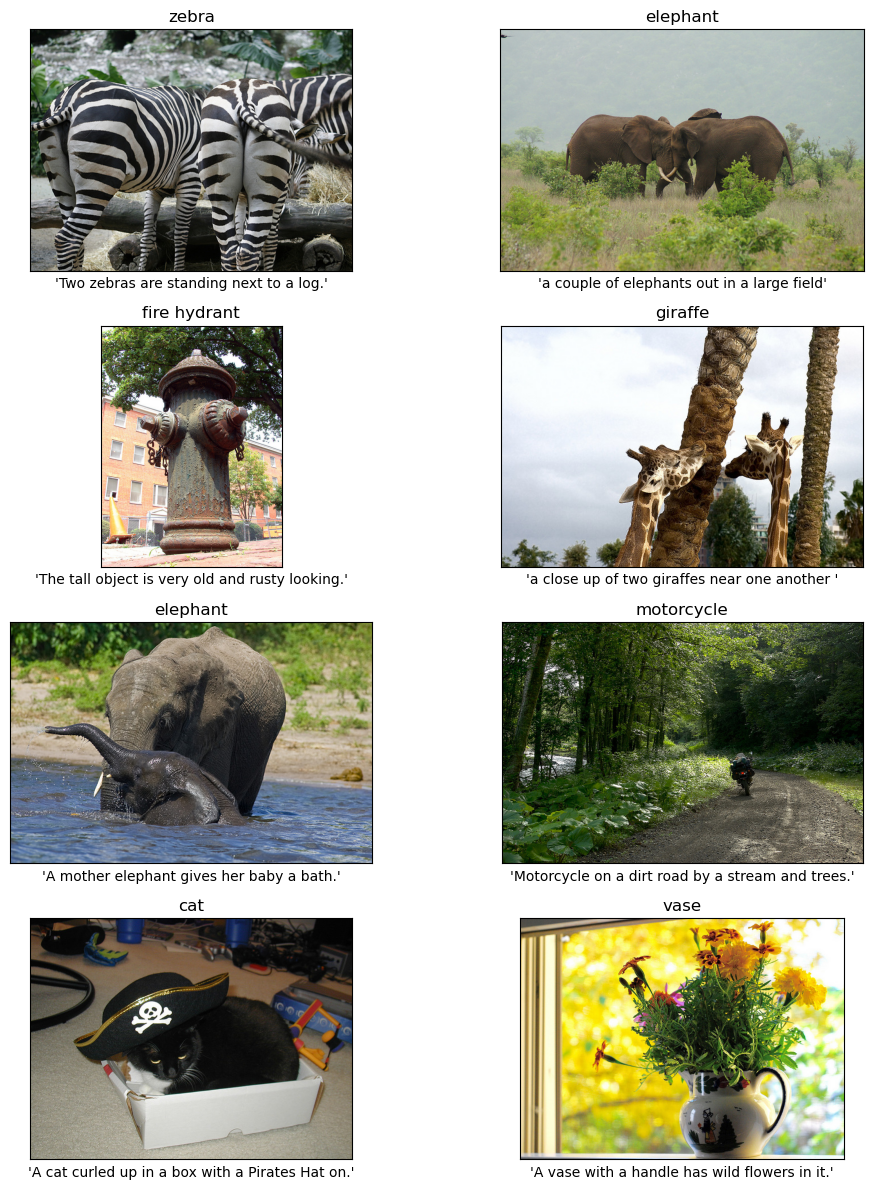

In [61]:
fig = plt.figure(figsize=(14,12))
example_ids = random.sample(list(range(len(df_samples))), 8)

for idx, id in enumerate(example_ids):
    ax = fig.add_subplot(len(example_ids)//2,2,idx+1)
    sample = df_samples.iloc[id] 
    img_path = sample['image']
    image = np.array(Image.open((img_path)).convert('RGB'))
    label_id = sample['label']
    label_str = COCO_dataset_preview.get_class_name(label_id)
    caption = sample['caption']
    
    ax.imshow(image)
    ax.set_title(label_str)
    ax.set_xlabel(f"'{caption}'")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

## Utils
Simple utils for tracking metrics and getting learning rate from optimizer.

In [62]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

## Encoders
For many multimodal models, you first need to encode features for each modality
you are using. 

In our case, we are interested in the image and text modalities, so we will
choose two suitable encoders, but the same approach can be applied to pretty
much any modalities you wanted to train a model on, e.g. lidar, audio, hyperspectral.

### Image Encoder

The image encoder code is straight forward. PyTorch Image Models library (timm) makes it easy to implement many different pre-trained image models such as ResNets and ViTs. Here we will use a TinyViT-21m pre-trained on ImageNet as our image encoder (as opposed to full-sized ViT or ResNet)

This network encodes each image to a fixed size vector with the size of the model's output channels (in the case of TinyViT-21m the vector size will be **576**). This is the output after the `nn.AdaptiveAvgPool2d()` layer in TinyViT.

In [63]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():  # ensure weights are not frozen
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

### Text Encoder

For text, a pre-trained DistilBERT is used as the text encoder. Like its bigger brother BERT, two special tokens will be added to the actual input tokens: **CLS** and **SEP** which mark the start and end of a sentence. To grab the whole representation of a sentence (as the related BERT and DistilBERT papers point out) we use the final representations of the CLS token and we hope that this representation captures the overall meaning of the sentence. By doing this, it is similar to what we did to images when converting them into a fixed size vector.

In the case of DistilBERT (and also BERT) the output hidden representation for each token is a vector with size **768**. So, the whole caption will be encoded in the CLS token representation whose size is 768.

In [64]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        # Return only the CLS token final hidden representation
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head


In [65]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

The general structure of CLIP is seen below:

<img src="https://raw.githubusercontent.com/mlfoundations/open_clip/main/docs/CLIP.png" alt="CLIP Overview" width="800" height="auto">

In [66]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
        num_classes=CFG.num_classes
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def loss_fn(self, image_embeddings, text_embeddings):
        # Compute logits for image and text embeddings
        ### NOTE how cross attention is computed here ###
        image_logits = image_embeddings @ text_embeddings.T * self.temperature
        text_logits = text_embeddings @ image_embeddings.T * self.temperature
        # Compute targets (knowing that labels are aligned)
        num_logits = image_logits.shape[0]
        targets = torch.arange(num_logits, device=image_embeddings.device, dtype=torch.long)
        # Compute cross entropy for each, maximising cosine similarity along diagonal
        image_loss = F.cross_entropy(image_logits, targets, reduction='none')
        text_loss = F.cross_entropy(text_logits, targets, reduction='none')
        loss =  (image_loss + text_loss) / 2.0 # shape: (batch_size)
        return loss.mean()
    
    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        ### NOTE: Projection and L2 normalisation lines can be left out in future ###
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # L2 normalise before computing cosine similarity
        image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
        text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)

        loss = self.loss_fn(image_embeddings_n, text_embeddings_n)
        
        return loss

In [67]:
class UnimodalImageModel(nn.Module):
    def __init__(self, num_classes=CFG.num_classes, image_embedding_size=CFG.image_embedding):
        super().__init__()
        self.image_encoder = ImageEncoder(trainable=False) # freeze encoder
        self.classifier = nn.Linear(image_embedding_size, num_classes)

    def forward(self, batch):
        # Getting Image Features
        image_features = self.image_encoder(batch["image"])

        # Classify based on image features
        logits = self.classifier(image_features)
        
        loss = F.cross_entropy(logits, batch["label"])
        return loss
    
class UnimodalTextModel(nn.Module):
    def __init__(self, num_classes=CFG.num_classes, text_embedding_size=CFG.text_embedding):
        super().__init__()
        self.text_encoder = TextEncoder(trainable=False) # freeze encoder
        self.classifier = nn.Linear(text_embedding_size, num_classes)

    def forward(self, batch):
        # Getting Text Features
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # Classify based on text features
        logits = self.classifier(text_features)
        loss = F.cross_entropy(logits, batch["label"])
        return loss
    
    
class CLIPClassifier(nn.Module):
    def __init__(
        self, 
        temperature=CFG.temperature, 
        num_classes=CFG.num_classes, 
        image_embedding=CFG.image_embedding, 
        text_embedding=CFG.text_embedding
    ):
        super().__init__()
        self.image_encoder = ImageEncoder(trainable=False)
        self.text_encoder = TextEncoder(trainable=False)
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature
        self.classifier = nn.Linear(in_features=(text_embedding+image_embedding), out_features=num_classes)  # Classification head 
        
    # def loss_fn(self, image_embeddings, text_embeddings):
    #     # Compute logits for image and text embeddings
    #     ### NOTE how cross attention is computed here ###
    #     image_logits = image_embeddings @ text_embeddings.T * self.temperature
    #     text_logits = text_embeddings @ image_embeddings.T * self.temperature
    #     # Compute targets (knowing that labels are aligned)
    #     num_logits = image_logits.shape[0]
    #     targets = torch.arange(num_logits, device=image_embeddings.device, dtype=torch.long)
    #     # Compute cross entropy for each, maximising cosine similarity along diagonal
    #     image_loss = F.cross_entropy(image_logits, targets, reduction='none')
    #     text_loss = F.cross_entropy(text_logits, targets, reduction='none')
    #     loss =  (image_loss + text_loss) / 2.0 # shape: (batch_size)
    #     return loss.mean()
    
    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # NOTE that a linear projection can be used before concatenating features,
        # to bring the distributions of each closer together

        # Concatenate features to create multimodal embedding
        joint_embeddings = torch.cat((image_features, text_features), 1)

        # Use joint embeddings for some downstream task (classification here)
        logits = self.classifier(joint_embeddings)
        
        # Do a suitable loss function (cross entropy loss for classification)
        loss = F.cross_entropy(logits, batch["label"])

        return loss.mean()

## Train
Here are some funtions to help us load training and validation dataloaders for our model, and then train and evaluate our model on those. There's not much going on here; just a simple training loop and utility functions.

**Your Turn:** No data augmentations are used other than resizing and normalizing in this example, which can increase the likelihood of model overfitting. Try adding some suitable augmentations here to improve the model's training.

In [68]:
def get_transforms(mode="train"):
    if mode == "train":
        return transforms.Compose([            
            transforms.Resize(size=(CFG.size, CFG.size), antialias=True),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            # Add suitable data augmentations here. Check out
            # https://pytorch.org/vision/0.17/transforms.html#v1-api-reference
            # for some ideas, and for easy implementation.
            #-----------------------YOUR CODE BELOW------------------------#
            
        ])
    else:
        return transforms.Compose([
            transforms.Resize(size=(CFG.size, CFG.size), antialias=True),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])


def build_loaders(tokenizer, mode, max_captions_per_image=5, max_samples=-1, dropped_modality=None, drop_ratio=0):
    transforms = get_transforms(mode=mode)
    if mode == 'train':
        split = 'train2017'
    elif mode == 'valid':
        split = 'val2017'
    else:
        raise ValueError('Invalid mode provided')
    if dropped_modality:
        assert (dropped_modality == 'text' or dropped_modality == 'image')
    dataset = COCOSingleClassDataset(
        data_dir=data_path,
        split=split,
        transforms=transforms,
        tokenizer=tokenizer,
        max_token_length=CFG.max_token_length,
        max_samples=max_samples,
        max_captions_per_image=max_captions_per_image,
        drop_data_mode=dropped_modality,
        drop_data_ratio=drop_ratio
    )
        
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [69]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != 'caption'}
        
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["input_ids"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader, dropped_modality='text'):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != 'caption'}
        loss = model(batch)

        count = batch["input_ids"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

        
def clip_main(train_loader, valid_loader, model_prefix="", model_suffix=""):
    model: CLIPModel = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain( 
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), f"{model_prefix}best{model_suffix}.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)
    return model

In [70]:
def train_unimodal_image(train_loader, valid_loader, model_prefix="", model_suffix=""):
    model = UnimodalImageModel().to(CFG.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.image_encoder_lr, weight_decay=CFG.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=CFG.patience, factor=CFG.factor)
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1} / {CFG.epochs}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), f"{model_prefix}best{model_suffix}.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)
    return model
        
def train_unimodal_text(train_loader, valid_loader, model_prefix="", model_suffix="", model:UnimodalTextModel=None):
    if (model == None):
        model = UnimodalTextModel().to(CFG.device)
    else:
        model = model.to(CFG.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.text_encoder_lr, weight_decay=CFG.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=CFG.patience, factor=CFG.factor)
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1} / {CFG.epochs}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), f"{model_prefix}best{model_suffix}.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)
    return model

def train_multimodal(train_loader, valid_loader, model_prefix="", model_suffix="", epoch_count=CFG.epochs):
    model: CLIPClassifier = CLIPClassifier().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain( 
            model.image_projection.parameters(), model.text_projection.parameters(), model.classifier.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(epoch_count):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), f"{model_prefix}best{model_suffix}.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)
    return model

Running the next cell starts training the model. Put the kernel on GPU mode if it isn't already. Every epoch should take about 15 minutes. It can take a few minutes before training actually starts because we are going to encode all the captions once in the training and validation dataset, so don't be alarmed if it hangs for a while.

If you want to see the best results possible though, leave this running for a couple hours or so before stopping it, but beware that Colab can sometimes timeout free users that train for too long. You can change the desired number of epochs in the CFG class, but one epoch is enough to get decent results.

If you get CUDA out of memory errors or similar, try reducing the batch size in the CFG class until the errors cease.

## Training

### Training Setup

In [71]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
# train_loader = build_loaders(tokenizer, mode="train", modality='image')
valid_loader = build_loaders(tokenizer, mode="valid")

/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating val2017 samples...


  0%|          | 0/1025 [00:00<?, ?it/s]

### Train 10% Samples

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', max_samples=2400)

Generating train2017 samples...


  0%|          | 0/2400 [00:00<?, ?it/s]

In [ ]:
image_model = train_unimodal_image(train_loader, valid_loader, model_prefix="img_" ,model_suffix="_10")

Epoch: 1 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 5 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 6 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 7 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 8 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 9 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 10 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


In [ ]:
text_model = train_unimodal_text(train_loader, valid_loader, model_prefix="txt_", model_suffix="_10")

Epoch: 1 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 5 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 6 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 7 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 8 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 9 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 10 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


In [ ]:
multimodal_model = train_multimodal(train_loader, valid_loader, model_prefix="multimodal_", model_suffix="_10")

/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch: 1


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 5


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 6


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 7


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 8


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 9


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


### Train 100% Samples

In [ ]:
train_loader = build_loaders(tokenizer, mode='train')

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg


In [ ]:
image_model = train_unimodal_image(train_loader, valid_loader, model_prefix="img_", model_suffix="_100")

Epoch: 1 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 5 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 6 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 7 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 8 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 9 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 10 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


In [ ]:
text_model = train_unimodal_text(train_loader, valid_loader, model_prefix="txt_", model_suffix="_100")

Epoch: 1 / 10


  0%|          | 0/1890 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
multimodal_model = train_multimodal(train_loader, valid_loader, model_prefix="multimodal_", model_suffix="_100")

/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch: 1


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 5


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 7


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

## Eval

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def accuracy(output, target, topk=(1,)):
    """
    Computes the precision@k for the specified values of k
    * Generated by ChatGPT
    """
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def get_image_model(model_path):
    model = UnimodalImageModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    return model

def get_text_model(model_path):
    model = UnimodalTextModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    return model

def get_multimodal_model(model_path):
    model = CLIPClassifier().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    return model

def get_clip_model(model_path):
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    return model


def evaluate_image_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    top1_acc = AvgMeter()
    top5_acc = AvgMeter()

    with torch.no_grad():
        for batch in tqdm(data_loader):
            images = batch["image"].to(CFG.device)
            labels = batch["label"].to(CFG.device)

            outputs = model.image_encoder(images)
            logits = model.classifier(outputs)
            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            top1, top5 = accuracy(logits, labels, topk=(1, 5))

            top1_acc.update(top1.item(), images.size(0))
            top5_acc.update(top5.item(), images.size(0))
            
    print(f"Top-1 Accuracy: {top1_acc.avg:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc.avg:.2f}%")
    return np.array(all_labels), np.array(all_preds), np.array([top1_acc.avg, top5_acc.avg])

def evaluate_text_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    top1_acc = AvgMeter()
    top5_acc = AvgMeter()

    with torch.no_grad():
        for batch in tqdm(data_loader):
            labels = batch["label"].to(CFG.device)
            masks = batch["attention_mask"].to(CFG.device)
            ids=batch["input_ids"].to(CFG.device)
            
            outputs = model.text_encoder(
                input_ids=ids, attention_mask=masks
            )
            logits = model.classifier(outputs)
            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            top1, top5 = accuracy(logits, labels, topk=(1, 5))

            top1_acc.update(top1.item(), masks.size(0))
            top5_acc.update(top5.item(), masks.size(0))
            
    print(f"Top-1 Accuracy: {top1_acc.avg:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc.avg:.2f}%")
    return np.array(all_labels), np.array(all_preds), np.array([top1_acc.avg, top5_acc.avg])

def evaluate_multimodal_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    top1_acc = AvgMeter()
    top5_acc = AvgMeter()

    with torch.no_grad():
        tqdm_object = tqdm(valid_loader, total=len(valid_loader))
        for batch in tqdm_object:
            labels = batch["label"].to(CFG.device)
            images = batch["image"].to(CFG.device)
            masks = batch["attention_mask"].to(CFG.device)
            ids=batch["input_ids"].to(CFG.device)
            
            # Getting Image and Text Features
            image_features = model.image_encoder(images)
            text_features = model.text_encoder(
                input_ids=ids, attention_mask=masks
            )
            # Concatenate features to create multimodal embedding
            joint_embeddings = torch.cat((image_features, text_features), 1)

            logits = model.classifier(joint_embeddings)
            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            top1, top5 = accuracy(logits, labels, topk=(1, 5))

            top1_acc.update(top1.item(), masks.size(0))
            top5_acc.update(top5.item(), masks.size(0))
            
    print(f"Top-1 Accuracy: {top1_acc.avg:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc.avg:.2f}%")
    return np.array(all_labels), np.array(all_preds), np.array([top1_acc.avg, top5_acc.avg])

def plot_confusion_matrix(true_labels, predicted_labels, num_classes):
    labels = np.arange(num_classes)
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels, normalize='all')
    cm_display = ConfusionMatrixDisplay(cm)

    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

### Image-only Eval

In [21]:
img_model_10 = get_image_model('img_best_10.pt')
img_model_100 = get_image_model('img_best_100.pt')

_, _, top_acc_img10 = evaluate_image_model(img_model_10, valid_loader)
_, _, top_acc_img100 = evaluate_image_model(img_model_100, valid_loader)


  0%|          | 0/80 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Text-only Eval

In [ ]:
txt_model_10 = get_text_model('txt_best_10.pt')
txt_model_100 = get_text_model('txt_best_100.pt')

_, _, top_acc_txt10 = evaluate_text_model(txt_model_10, valid_loader)
_, _, top_acc_txt100 = evaluate_text_model(txt_model_100, valid_loader)

/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 20.43%
Top-5 Accuracy: 44.98%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 64.10%
Top-5 Accuracy: 85.44%


### Plotting Unimodal Eval

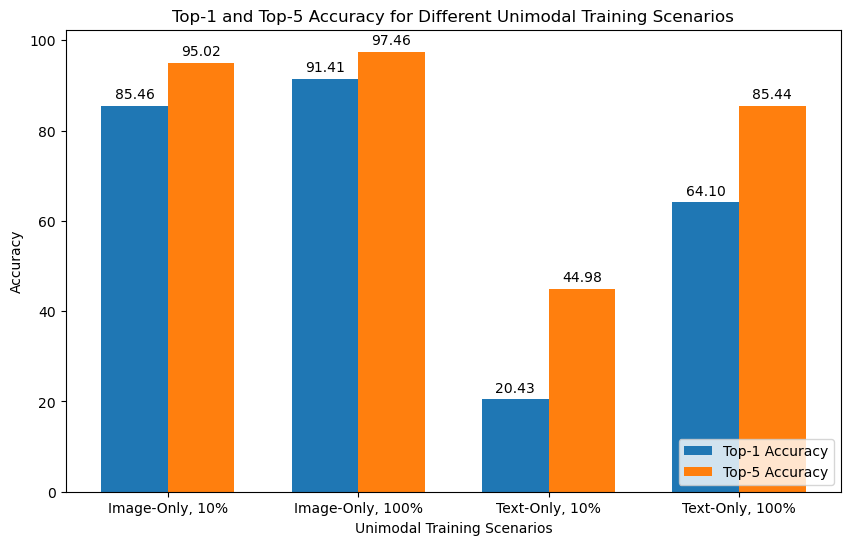

In [ ]:
scenarios = ['Image-Only, 10%', 'Image-Only, 100%', 'Text-Only, 10%', 'Text-Only, 100%']
top1_acc = [top_acc_img10[0], top_acc_img100[0], top_acc_txt10[0], top_acc_txt100[0]]
top5_acc = [top_acc_img10[1], top_acc_img100[1], top_acc_txt10[1], top_acc_txt100[1]]
# X-axis locations
x = np.arange(len(scenarios))
# Bar width
width = 0.35
# Plotting
fig, ax = plt.subplots(figsize=(10,6))
# Bars for top-1 accuracy
bars1 = ax.bar(x - width/2, top1_acc, width, label='Top-1 Accuracy')
# Bars for top-5 accuracy
bars2 = ax.bar(x + width/2, top5_acc, width, label='Top-5 Accuracy')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Unimodal Training Scenarios')
ax.set_ylabel('Accuracy')
ax.set_title('Top-1 and Top-5 Accuracy for Different Unimodal Training Scenarios')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(loc='lower right')

# Labeling the bars with their values
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

### Multimodal Eval

In [ ]:
multimodal_model_10 = get_multimodal_model('multimodal_best_10.pt')
multimodal_model_100 = get_multimodal_model('multimodal_best_100.pt')

_, _, top_acc_clip10 = evaluate_multimodal_model(multimodal_model_10, valid_loader)
_, _, top_acc_clip100 = evaluate_multimodal_model(multimodal_model_100, valid_loader)

/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 91.65%
Top-5 Accuracy: 97.58%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 94.48%
Top-5 Accuracy: 98.54%


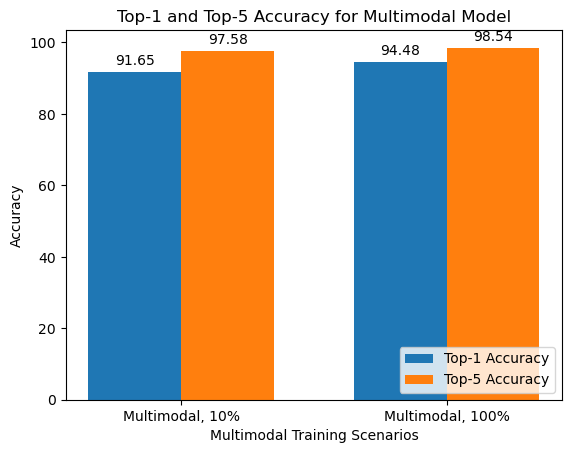

In [ ]:
scenarios = ['Multimodal, 10%', 'Multimodal, 100%']
top1_acc = [top_acc_clip10[0], top_acc_clip100[0]]
top5_acc = [top_acc_clip10[1], top_acc_clip100[1]]
# X-axis locations
x = np.arange(len(scenarios))
# Bar width
width = 0.35
# Plotting
fig, ax = plt.subplots()
# Bars for top-1 accuracy
bars1 = ax.bar(x - width/2, top1_acc, width, label='Top-1 Accuracy')
# Bars for top-5 accuracy
bars2 = ax.bar(x + width/2, top5_acc, width, label='Top-5 Accuracy')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Multimodal Training Scenarios')
ax.set_ylabel('Accuracy')
ax.set_title('Top-1 and Top-5 Accuracy for Multimodal Model')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(loc='lower right')

# Labeling the bars with their values
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

## Self-Supervised Learning

In [ ]:
train_loader = build_loaders(tokenizer, mode='train')

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg


In [ ]:
# CLIP pre-training SSL
clip_pt_model = clip_main(train_loader, valid_loader, model_prefix="preclip_", model_suffix="")

/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch: 1


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 5


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
# Update encoder weights
text_model: UnimodalTextModel = UnimodalTextModel()
text_model.text_encoder.load_state_dict(clip_pt_model.text_encoder.state_dict())

<All keys matched successfully>

In [ ]:
# Use 10% labels
train_loader = build_loaders(tokenizer, mode='train', max_samples=2400)

# train
text_model = train_unimodal_text(train_loader, valid_loader, model_prefix="text_pt_", model_suffix="_10")

Generating train2017 samples...


  0%|          | 0/2400 [00:00<?, ?it/s]

Epoch: 1 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 5 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 6 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 7 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 8 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 9 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 10 / 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


### SSL Eval

In [ ]:
# Load Model
text_model: UnimodalTextModel = get_text_model(model_path='text_pt_best_10.pt')

/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Eval
_, _, top_acc_txt10_clip = evaluate_text_model(text_model, valid_loader)


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 22.17%
Top-5 Accuracy: 44.37%


In [ ]:
txt_model_10 = get_text_model('txt_best_10.pt')
txt_model_100 = get_text_model('txt_best_100.pt')

_, _, top_acc_txt10 = evaluate_text_model(txt_model_10, valid_loader)
_, _, top_acc_txt100 = evaluate_text_model(txt_model_100, valid_loader)

  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 20.43%
Top-5 Accuracy: 44.98%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 64.10%
Top-5 Accuracy: 85.44%


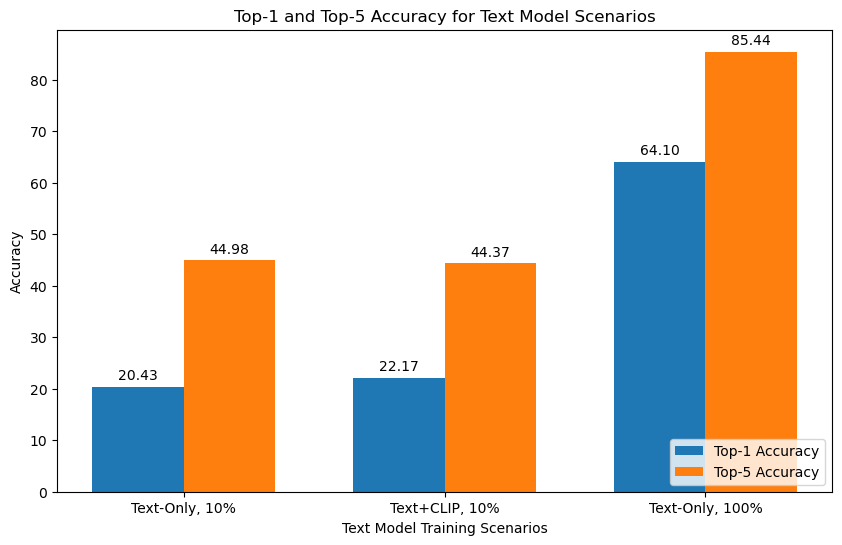

In [ ]:
scenarios = ['Text-Only, 10%', 'Text+CLIP, 10%', 'Text-Only, 100%']
top1_acc = [top_acc_txt10[0], top_acc_txt10_clip[0], top_acc_txt100[0]]
top5_acc = [top_acc_txt10[1], top_acc_txt10_clip[1], top_acc_txt100[1]]
# X-axis locations
x = np.arange(len(scenarios))
# Bar width
width = 0.35
# Plotting
fig, ax = plt.subplots(figsize=(10,6))
# Bars for top-1 accuracy
bars1 = ax.bar(x - width/2, top1_acc, width, label='Top-1 Accuracy')
# Bars for top-5 accuracy
bars2 = ax.bar(x + width/2, top5_acc, width, label='Top-5 Accuracy')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Text Model Training Scenarios')
ax.set_ylabel('Accuracy')
ax.set_title('Top-1 and Top-5 Accuracy for Text Model Scenarios')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(loc='lower right')

# Labeling the bars with their values
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

## Modality Ablation

### Image Ablation - This is incorrect, supposed to be testing set, not training

#### 100% image

In [21]:
train_loader = build_loaders(tokenizer, mode='train')
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_100img_", epoch_count=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg


/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch: 1


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


#### 90% image

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='image', drop_ratio=0.1)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_90img_", epoch_count=1)

#### 80% image

In [22]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='image', drop_ratio=0.2)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_80img_", epoch_count=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg
Epoch: 1


  0%|          | 0/1890 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### 70% Image

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='image', drop_ratio=0.3)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_70img_", epoch_count=1)

#### 60% Image

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='image', drop_ratio=0.4)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_60img_", epoch_count=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg


/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch: 1


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


#### 50% image

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='image', drop_ratio=0.5)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_50img_")

#### 40% image

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='image', drop_ratio=0.6)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_40img_", epoch_count=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg
Epoch: 1


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


#### 30% image

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='image', drop_ratio=0.7)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_30img_", epoch_count=1)

#### 20% Image

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='image', drop_ratio=0.8)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_20img_", epoch_count=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg


/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch: 1


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


#### 10% Image

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='image', drop_ratio=0.9)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_10img_")

#### 0% Image

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='image', drop_ratio=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg


In [ ]:
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_0img_", epoch_count=1)

Epoch: 1


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


### Text Ablation - This is incorrect, supposed to be testing set, not training

#### 100% Text

In [21]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='text', drop_ratio=0)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_100txt_", epoch_count=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg


/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch: 1


  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


#### 80% Text

In [21]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='text', drop_ratio=0.2)


Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg


/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch: 1


  0%|          | 0/1878 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_80txt_", epoch_count=1)

Epoch: 1


  0%|          | 0/1878 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


#### 60% Text

In [23]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='text', drop_ratio=0.4)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_60txt_", epoch_count=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg
Epoch: 1


  0%|          | 0/1865 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


#### 40% Text

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='text', drop_ratio=0.6)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_40txt_", epoch_count=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

#### 20% Text

In [ ]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='text', drop_ratio=0.8)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_20txt_", epoch_count=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg
Epoch: 1


  0%|          | 0/1839 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


#### 0% Text

In [26]:
train_loader = build_loaders(tokenizer, mode='train', dropped_modality='text', drop_ratio=1)
multimodal_img = train_multimodal(train_loader, valid_loader, model_prefix="mm_0txt_", epoch_count=1)

Generating train2017 samples...


  0%|          | 0/24186 [00:00<?, ?it/s]

Skipped corrupted image ./coco_single_class/train2017/000000156113.jpg


/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch: 1


  0%|          | 0/1827 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved Best Model!


### Evaluation - This is incorrect, supposed to be testing set, not training

In [21]:
mm_img_drop_model = get_multimodal_model('mm_100img_best.pt')
_, _, top_acc_100img_mm = evaluate_multimodal_model(mm_img_drop_model, valid_loader)
#
mm_img_drop_model = get_multimodal_model('mm_80img_best.pt')
_, _, top_acc_80img_mm = evaluate_multimodal_model(mm_img_drop_model, valid_loader)
#
mm_img_drop_model = get_multimodal_model('mm_60img_best.pt')
_, _, top_acc_60img_mm = evaluate_multimodal_model(mm_img_drop_model, valid_loader)
#
mm_img_drop_model = get_multimodal_model('mm_40img_best.pt')
_, _, top_acc_40img_mm = evaluate_multimodal_model(mm_img_drop_model, valid_loader)
#
mm_img_drop_model = get_multimodal_model('mm_20img_best.pt')
_, _, top_acc_20img_mm = evaluate_multimodal_model(mm_img_drop_model, valid_loader)
#
mm_img_drop_model = get_multimodal_model('mm_0img_best.pt')
_, _, top_acc_0img_mm = evaluate_multimodal_model(mm_img_drop_model, valid_loader)

/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 93.76%
Top-5 Accuracy: 98.19%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 94.09%
Top-5 Accuracy: 97.93%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 93.91%
Top-5 Accuracy: 98.19%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 94.07%
Top-5 Accuracy: 98.19%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 93.95%
Top-5 Accuracy: 98.20%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 94.15%
Top-5 Accuracy: 98.17%


In [24]:
mm_txt_drop_model = get_multimodal_model('mm_100txt_best.pt')
_, _, top_acc_100txt_mm = evaluate_multimodal_model(mm_txt_drop_model, valid_loader)
#
mm_txt_drop_model = get_multimodal_model('mm_80txt_best.pt')
_, _, top_acc_80txt_mm = evaluate_multimodal_model(mm_txt_drop_model, valid_loader)
#
mm_txt_drop_model = get_multimodal_model('mm_60txt_best.pt')
_, _, top_acc_60txt_mm = evaluate_multimodal_model(mm_txt_drop_model, valid_loader)
#
mm_txt_drop_model = get_multimodal_model('mm_40txt_best.pt')
_, _, top_acc_40txt_mm = evaluate_multimodal_model(mm_txt_drop_model, valid_loader)
#
mm_txt_drop_model = get_multimodal_model('mm_20txt_best.pt')
_, _, top_acc_20txt_mm = evaluate_multimodal_model(mm_txt_drop_model, valid_loader)
#
mm_img_drop_model = get_multimodal_model('mm_0txt_best.pt')
_, _, top_acc_0txt_mm = evaluate_multimodal_model(mm_img_drop_model, valid_loader)

  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 93.91%
Top-5 Accuracy: 98.20%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 91.40%
Top-5 Accuracy: 97.74%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 91.08%
Top-5 Accuracy: 97.68%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 90.87%
Top-5 Accuracy: 97.60%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 91.41%
Top-5 Accuracy: 97.21%


  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 91.20%
Top-5 Accuracy: 97.52%


### Proper Ablation:

In [21]:
multimodal_model = get_multimodal_model('multimodal_best_100.pt')

/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#### Image Ablation:

In [55]:
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='image', drop_ratio=0)
_, _, top_acc_100img_mm = evaluate_multimodal_model(multimodal_model, valid_loader)
#
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='image', drop_ratio=0.2)
_, _, top_acc_80img_mm = evaluate_multimodal_model(multimodal_model, valid_loader)
#
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='image', drop_ratio=0.4)
_, _, top_acc_60img_mm = evaluate_multimodal_model(multimodal_model, valid_loader)
#
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='image', drop_ratio=0.6)
_, _, top_acc_40img_mm = evaluate_multimodal_model(multimodal_model, valid_loader)
#
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='image', drop_ratio=0.8)
_, _, top_acc_20img_mm = evaluate_multimodal_model(multimodal_model, valid_loader)
#
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='image', drop_ratio=1)
_, _, top_acc_0img_mm = evaluate_multimodal_model(multimodal_model, valid_loader)

Generating val2017 samples...


  0%|          | 0/1025 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 94.48%
Top-5 Accuracy: 98.54%
Generating val2017 samples...


  0%|          | 0/1025 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 91.22%
Top-5 Accuracy: 97.72%
Generating val2017 samples...


  0%|          | 0/1025 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 88.86%
Top-5 Accuracy: 96.92%
Generating val2017 samples...


  0%|          | 0/1025 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 85.27%
Top-5 Accuracy: 95.32%
Generating val2017 samples...


  0%|          | 0/1025 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 82.03%
Top-5 Accuracy: 94.17%
Generating val2017 samples...


  0%|          | 0/1025 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 78.32%
Top-5 Accuracy: 93.15%


#### Text Ablation

In [73]:
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='text', drop_ratio=0)
_, _, top_acc_100txt_mm = evaluate_multimodal_model(multimodal_model, valid_loader)
#
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='text', drop_ratio=0.2)
_, _, top_acc_80txt_mm = evaluate_multimodal_model(multimodal_model, valid_loader)
#
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='text', drop_ratio=0.4)
_, _, top_acc_60txt_mm = evaluate_multimodal_model(multimodal_model, valid_loader)
#
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='text', drop_ratio=0.6)
_, _, top_acc_40txt_mm = evaluate_multimodal_model(multimodal_model, valid_loader)
#
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='text', drop_ratio=0.8)
_, _, top_acc_20txt_mm = evaluate_multimodal_model(multimodal_model, valid_loader)
#
valid_loader = build_loaders(tokenizer, mode='valid', dropped_modality='text', drop_ratio=1)
_, _, top_acc_0txt_mm = evaluate_multimodal_model(multimodal_model, valid_loader)

Generating val2017 samples...


  0%|          | 0/1025 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Top-1 Accuracy: 94.48%
Top-5 Accuracy: 98.54%
Generating val2017 samples...


  0%|          | 0/1025 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/cameron/miniforge3/envs/enn585/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_971775/2396759739.py", line 114, in __getitem__
    item['input_ids'] = torch.tensor(None)
RuntimeError: Could not infer dtype of NoneType


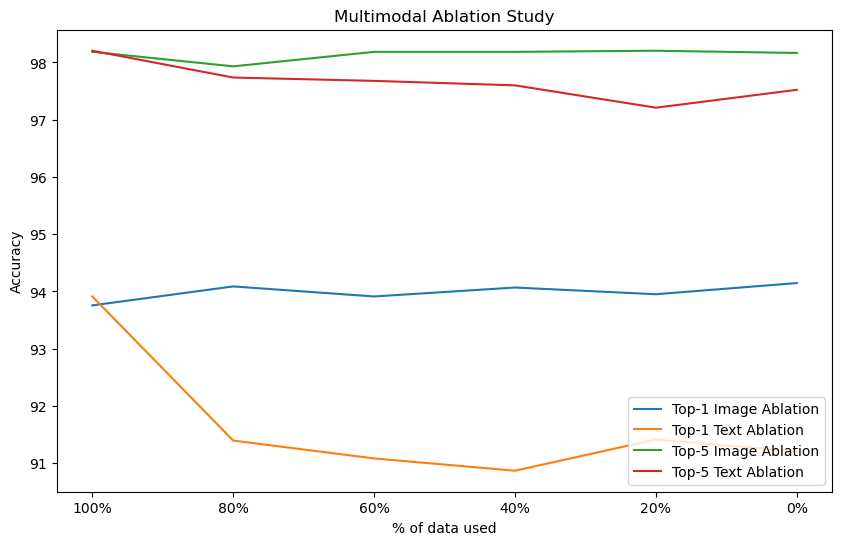

In [ ]:
scenarios = ['100%', '80%', '60%', '40%', '20%', '0%']
top1_acc_img_drop = [top_acc_100img_mm[0], top_acc_80img_mm[0], top_acc_60img_mm[0], top_acc_40img_mm[0], top_acc_20img_mm[0], top_acc_0img_mm[0]]
top1_acc_txt_drop = [top_acc_100txt_mm[0], top_acc_80txt_mm[0], top_acc_60txt_mm[0], top_acc_40txt_mm[0], top_acc_20txt_mm[0], top_acc_0txt_mm[0]]

top5_acc_img_drop = [top_acc_100img_mm[1], top_acc_80img_mm[1], top_acc_60img_mm[1], top_acc_40img_mm[1], top_acc_20img_mm[1], top_acc_0img_mm[1]]
top5_acc_txt_drop = [top_acc_100txt_mm[1], top_acc_80txt_mm[1], top_acc_60txt_mm[1], top_acc_40txt_mm[1], top_acc_20txt_mm[1], top_acc_0txt_mm[1]]
# X-axis locations
x = np.arange(len(scenarios))
# Bar width
width = 0.35
# Plotting
fig, ax = plt.subplots(figsize=(10,6))
# Lines for top-1 accuracy
series1 = ax.plot(x, top1_acc_img_drop, label='Top-1 Image Ablation')
series2 = ax.plot(x, top1_acc_txt_drop, label='Top-1 Text Ablation')
# Lines for top-5 accuracy
series3 = ax.plot(x, top5_acc_img_drop, label='Top-5 Image Ablation')
series4 = ax.plot(x, top5_acc_txt_drop, label='Top-5 Text Ablation')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('% of data used')
ax.set_ylabel('Accuracy')
ax.set_title('Multimodal Ablation Study')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(loc='lower right')

# Getting Image Embeddings
In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape `(valid_set_size, 256)` and the model itself.

In [ ]:
def get_image_embeddings(model_path, valid_loader):
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    print("Getting image embeddings...")
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [ ]:
model, image_embeddings = get_image_embeddings("best.pt", valid_loader)

### Finding Matches
Now to see if the model can match text to images. This function takes the model, image_embeddings, and a text query, and displays the most relevant images it finds in the validation set. Note the use of cosine similarity once again to determine image and text similarity, followed by a top-k operation to retrieve the k most similar images.

In [ ]:
def find_matches(model, tokenizer, image_embeddings, query, df_samples, n=9):
    image_filenames = df_samples['image']
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    cos_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(cos_similarity.squeeze(0), n * 5)
    matches = [image_filenames[int(idx)] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = np.array(Image.open(match))
        ax.imshow(image)
        ax.axis("off")

    plt.show()

If all went well, you should hopefully see some photos of zebras running on grass. If not, you may need to train for a few more epochs. Feel free to change the query and see what else CLIP has learnt, although note that the COCO single class subset is not all-encompassing, and many queries simply won't exist in the data.

In [ ]:
find_matches(model,
             tokenizer,
             image_embeddings,
             query="zebras running on grass",
             df_samples=valid_loader.dataset.df_samples,
             n=9)

## Zero-Shot Transfer
So how can we use CLIP for tasks other than text-based image retrieval? In the
CLIP paper, the authors demonstrate that CLIP pre-training exhibits strong
generalisation to many unseen datasets and downstream tasks. They demonstrate
impressive results for zero-shot classification, representation learning, and 
robustness to distribution shift. 

We will now adapt our CLIP model to do zero-shot classification. The key
part of zero-shot classification is the classifier is never trained specifically
to classify images into specific classes. Compare this to the common approach of
linear probing a pre-trained model, where a linear classifier is trained on a
small subset of data using the pre-trained features from the model.

In CLIP zero-shot, classification is done using the feature similarity matching
component. A text embedding for each class is pre-computed, and then for each
image in the test set, the image embedding is compared with the text embeddings
to find the most similar pair, which indicates the selected class.

### CLIP Zero Shot Model
We adapt the existing CLIP model for zero shot by ignoring the sample captions,
and instead computing similarity between image embeddings and the embeddings of
all 80 class labels, which we will precompute in another function.

In [ ]:
class CLIPZeroShotModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature
    
    def forward(self, batch):
        # Just getting Image Features, as Text Embeddings are pre-computed
        image_features = self.image_encoder(batch["image"])
        
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)

        # L2 normalise
        image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)

        # Compute logits
        logits = image_embeddings_n @ batch["label_embeddings_n"].T * self.temperature
        
        return logits

### Pre-computing label embeddings
We now need to tokenize and compute embeddings for all the class labels. We could
just use the class label as an input query, but as our model was trained on sentence
captions describing the image, it would be better if we choose a sentence such as
"A photo of a {class}". You can employ some level of prompt engineering to find
a better prompt depending on the context of the image, but this naive approach
will work well enough for most images.

Below we embed all our class labels within this query template, tokenize them all,
and compute the pre-trained model embeddings for all classes. These will be
passed to our altered CLIP model.

In [ ]:
def get_label_embeddings(model, valid_loader, tokenizer, query_template="A photo of a "):
    model.eval()    
    print("Getting label embeddings...")
    label_list = list(valid_loader.dataset.class_name_dict.keys()) # use this to get original class idx back
    label_queries = []
    # Generate query sentences, and tokenize them
    for label_id in label_list:
        label_str = valid_loader.dataset.get_class_name(label_id)  # get class name associated with label id
        label_queries.append(f"{query_template}{label_str}.")  # e.g. "A photo of a zebra."        
    encoded_queries = tokenizer(
        label_queries, padding=True, truncation=True, max_length=CFG.max_token_length
    )

    # Create batch for queries
    batch = {}
    for key, values in encoded_queries.items():
        batch[key] = torch.tensor(values).to(CFG.device)

    # Get embeddings from model
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        label_embeddings = model.text_projection(text_features)
        label_embeddings_n = F.normalize(label_embeddings, p=2, dim=-1)
            
    return label_embeddings_n, label_list

Below we define an evaluation loop for zero-shot classification using the val
set. We first precompute the label embeddings with the function defined above,
then in a loop, we get the logits from the model, softmax them to make them a
probability distribution, and use argmax to find the predicted class (which will
be the one with the highest probability). We then count the number of correct
retrievals. Accuracy is the reported metric here.

In [ ]:
def zero_shot_eval(model_path, valid_loader, tokenizer):
    model = CLIPZeroShotModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    # Pre-compute text embeddings for all classes
    label_embeddings_n, label_list = get_label_embeddings(model, valid_loader, tokenizer, query_template="A photo of a ")
    label_list = np.array(label_list)
    num_success = 0
    print(f"Evaluating...")
    with torch.no_grad():
        tqdm_object = tqdm(valid_loader, total=len(valid_loader))
        for batch in tqdm_object:
            # Add label embeddings to batch, we will ignore regular text embeddings
            batch['label_embeddings_n'] = label_embeddings_n
            batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
            # Compute softmax of logits, count highest prob class as model classification
            logits = model(batch)
            probs = F.softmax(logits, dim=-1)
            pred = torch.argmax(probs, dim=-1)
            pred_id_fix = label_list[pred.cpu().numpy()]
            # Count number of successful classifications
            num_success += np.count_nonzero(pred_id_fix == batch["label"].cpu().numpy())

    # Report accuracy
    accuracy = num_success / len(valid_loader.dataset)
    print(f"Model accuracy: {accuracy:.3f}")

And now we can evaluate zero shot performance! Note that we need to load a separate
dataloader here. We are using the COCO single class validation set, but since we
are not using captions, we only want to evaluate 1 sample per image, to prevent
redundant evaluations. 

In [ ]:
# Only load 1 caption per image, so that each image is only evaluated once
valid_loader_zero_shot = build_loaders(tokenizer, mode="valid", max_captions_per_image=1)
zero_shot_eval("best.pt", valid_loader_zero_shot, tokenizer)

Hopefully your accuracy is somewhat high, but if not, then it's an indication
that your model needs to be trained for longer. Keep in mind we are starting
with an image and text encoder that have already been pre-trained on datasets
relatively similar to COCO, so the domain gap is relatively small. In the CLIP
paper, pre-training is done entirely from scratch, but this requires massive
batch sizes and number of epochs, and a suitably massive dataset to properly
train the model. 

## Fine-Tuning CLIP with Learnable Prompts
In this example, we have elected to make a relatively small version of CLIP (when compared to the billions of parameters learnt by the real model), and trained on a small dataset of 10k images, compared to the 400 million images in the WIT dataset. As a result, this model is fairly quick to train and would be easy to fine-tune on a new dataset. But what if you wanted to take advantage of the full capabilities of CLIP? If you had the compute power of OpenAI or Google, then this would take a matter of days, but for most people, these models are simply too large to train. Fine-tuning also runs the risk of catastrophic forgetting, where the strong generalisation that CLIP learnt through massive pre-training is diminished, and the risk of overfitting increases.

New research has been pushing in the direction of making CLIP practical to fine-tune, while preventing loss of generalisation. One popular method to do this is prompt learning. In the zero-shot classification setting of the base CLIP model, prompts are typically handcrafted by generating an input sequence like, "a photo of a [CLASS]", to make the class label more similar to the captions CLIP was trained on. However, [Context Optimization (CoOp)](https://arxiv.org/abs/2109.01134) argues that handcrafted prompts may not always provide the best context for CLIP, and instead proposes learnable prompts for the text encoder. These prompts take the form "$[V]_1[V]_2...[V]_M[\mathrm{CLASS}]$", where each $[V]_M$ is a learnable vector with the same dimensionality as the word embeddings. The class token can also be placed in the middle of the prompt to increase flexibility. During fine-tuning, the massive pre-trained parameters of the image and text encoders are frozen, while the prompts remain learnable, allowing CoOp to optimize context tokens to the new dataset, without losing the generalisation performance learnt during training.

<img src="https://minio.cvmart.net/cvmart-community/images/202206/30/0/006C3FgEgy1gv4byc8i00j60j508pac402.jpg" alt="CoOp Diagram" width="800" height="auto">

However, CoOp only learns to optimize these prompts on the text encoder of CLIP, ignoring the image encoder. To amend this, [Multi-modal Prompt Learning (MaPLe)](https://arxiv.org/pdf/2210.03117.pdf) allows the learnable prompts to influence the text and image encoders, and couples the optimization on both by making the image prompts a learnable linear projection of the text prompts. Approaches like [Multimodal Prompting with Missing Modalities for Visual Recognition](https://openaccess.thecvf.com/content/CVPR2023/papers/Lee_Multimodal_Prompting_With_Missing_Modalities_for_Visual_Recognition_CVPR_2023_paper.pdf) even allow for multimodal classification models to stay performant when a modality is missing, simply by learning prompts that are aware of missing modalities. 

**Your turn:** As an extension challenge, try alter the above zero-shot classification code to fine-tune on the data by swapping the fixed prompts for learnable prompts similar to CoOp, and see if performance improves. 

In [ ]:
# Redefine the Zero Shot class but with learnable tokens (you may want to use nn.Parameter() or similar)
class CLIPZeroShotLearnableTokensModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature
        
        #-----------------------YOUR CODE BELOW------------------------#
        ## NOTE: Define learnable parameter here
        self.learnable_prompt = None
    
    def forward(self, batch):
        # Just getting Image Features, as Text Embeddings are pre-computed
        image_features = self.image_encoder(batch["image"])
        
        #-----------------------YOUR CODE BELOW------------------------#
        # Pass the class label through here. 
        # Note that you may want to edit the zero_shot_eval code to pass all
        # class labels to the batch element, so that the learnable prompts can
        # be applied here. There are a few ways to do this, either in this 
        # class, or in a separate class.
        label_embeddings_n = self.learnable_prompt(batch["all_labels"])
        
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)

        # L2 normalise
        image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)

        # Compute logits
        logits = image_embeddings_n @ label_embeddings_n.T * self.temperature
        
        return logits